In [2]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#let-s-use-conll-2002-data-to-build-a-ner-system
# functions to create NER features

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [3]:
import json

# convert the sentence-word triples into features
dataset = json.load(open('scenarios-training-0.json'))

X_train = [sent2features(s) for scenario in dataset['train'] for s in scenario['tokens']]
y_train = [sent2labels(s) for scenario in dataset['train'] for s in scenario['tokens']]
X_test = [sent2features(s) for scenario in dataset['validation'] for s in scenario['tokens']]
y_test = [sent2labels(s) for scenario in dataset['validation'] for s in scenario['tokens']]

In [11]:
import json

if True:
    # convert the sentence-word triples into features
    dataset = json.load(open('sentences-training-N.json'))

    X_train = [sent2features(s['tokens']) for s in dataset['train']]
    y_train = [sent2labels(s['tokens']) for s in dataset['train']]
    X_test = [sent2features(s['tokens']) for s in dataset['validation']]
    y_test = [sent2labels(s['tokens']) for s in dataset['validation']]

In [12]:
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF

# split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# create and fit the model
crf = CRF(algorithm = 'lbfgs',
         c1 = 0.07464225463730761,
         c2 = 0.14714217627435802,
         max_iterations = 100,
         all_possible_transitions = False)

crf.fit(X_train, y_train)

labels = list(crf.classes_)
labels.remove('O')

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

# define fixed parameters and parameters to search
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)



Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.9min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb9f7e1b0d0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb9f7e33d00>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-SIM', 'I-SIM', 'B-COM', 'I-COM', 'B-QUE', 'I-QUE']),
                   verbose=1)

In [14]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
#print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.2615466326335233, 'c2': 0.0508600179206012}
best CV score: 0.5715139022976378


Dark blue => 0.5233, dark red => 0.5715


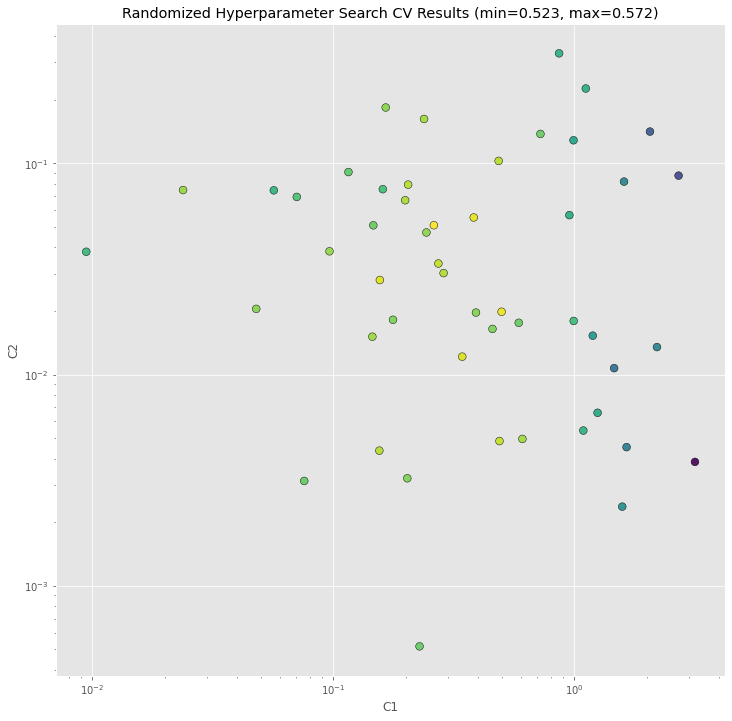

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [62]:
rs.cv_results_

{'mean_fit_time': array([4.29459969, 4.3129437 , 4.638357  , 5.068964  , 4.84435932,
        4.8503503 , 4.94233831, 4.92807531, 5.15532629, 4.93334627,
        4.9524862 , 5.16935039, 4.98231514, 4.87645586, 5.03205506,
        5.24706316, 5.0358208 , 5.03495693, 5.02828399, 5.00775663,
        4.92524362, 4.83011961, 4.86078811, 4.76753449, 4.75967797,
        4.90034302, 4.8186059 , 5.18529471, 5.1517787 , 5.16132037,
        5.3277723 , 5.1519676 , 4.9141914 , 5.07463153, 5.02362196,
        4.96407874, 5.16683356, 4.99503263, 5.07371831, 5.08369398,
        5.04971441, 5.11738841, 5.23628974, 5.15401769, 5.21956237,
        5.28278637, 5.14724215, 5.03926039, 4.45073557, 3.77871823]),
 'std_fit_time': array([0.13797076, 0.14293118, 0.39633493, 0.31982785, 0.12909975,
        0.15692383, 0.15326224, 0.16639063, 0.23519921, 0.08674806,
        0.26403286, 0.26068566, 0.10183403, 0.09010884, 0.19498099,
        0.18347025, 0.0897465 , 0.10098418, 0.11642768, 0.14642313,
        0.118